# COVID-19 Modeling

Name: Lydia Jeong <br>
University of Toronto <br>
December 18, 2020

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with the COVID-19 virus experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness. The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes. In this project, we will model spread of the coronavirus and study how we can project and plan for best and worst case scenarios as we are in the midst of the 2nd wave. 
<br><br>
The dataset we will be using to accomplish this is the COVID-19 Data Repository from the Center for Systems Science and Engineering (CSSE) at John Hopkins University (https://github.com/CSSEGISandData/COVID-19). This dataset has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus. 
<br><br>
The goal of this project is to develop data science or machine learning models that forecast COVID-19 cases with the aim of helping policymakers plan for the days and months ahead, and take action to change the course of the pandemic for the better.

## Install and import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# show plots inline for notebooks
%matplotlib inline
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 1: Data Cleaning

In [2]:
# Load the dataset about COVID-19 in USA into Pandas dataframe.
url_covid = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv" 
df = pd.read_csv(url_covid)
# Display the first five rows of the dataframe
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2328,2328,2351,2385,2417,2435,2456,2481,2506,2529,2554,2580,2597,2617,2634,2661,2686,2704,2716,2735,2751,2780,2818,2873,2893,2945,2979,3005,3043,3087,3117,3186,3233,3258,3300,3329,3426,3510,3570,3647
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7345,7348,7409,7454,7523,7596,7646,7696,7772,7849,7933,8038,8131,8199,8269,8376,8473,8576,8603,8733,8820,8890,9051,9163,9341,9501,9626,9728,9821,9974,10087,10288,10489,10665,10806,10898,11061,11212,11364,11556
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1107,1107,1112,1113,1117,1123,1128,1130,1134,1137,1145,1151,1157,1160,1161,1167,1170,1170,1171,1173,1175,1178,1189,1206,1214,1217,1219,1223,1224,1240,1245,1258,1264,1269,1272,1275,1292,1296,1309,1318
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,948,948,961,966,973,978,986,993,1004,1008,1011,1024,1036,1136,1142,1157,1162,1170,1173,1179,1188,1196,1204,1239,1252,1270,1283,1293,1299,1317,1322,1359,1398,1417,1441,1455,1504,1520,1548,1577
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2378,2378,2400,2429,2488,2518,2549,2574,2594,2648,2683,2704,2735,2754,2763,2822,2855,2879,2888,2922,2946,2997,3061,3100,3158,3231,3281,3299,3324,3426,3496,3600,3663,3744,3776,3803,3881,3950,4036,4118


In [3]:
# Display the last five rows of the dataframe
df.tail()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1007,1022,1025,1066,1108,1156,1178,1192,1252,1271,1298,1336,1360,1371,1433,1442,1476,1476,1547,1570,1606,1644,1655,1678,1693,1724,1739,1785,1810,1822,1834,1852,1868,1886,1905,1930,1940,1958,1974,1990
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,568,614,627,664,686,719,729,760,796,835,869,894,901,920,950,982,1016,1016,1037,1037,1046,1070,1089,1121,1149,1175,1187,1198,1221,1237,1250,1271,1281,1289,1307,1327,1352,1363,1372,1399
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,190,197,199,203,206,208,218,227,253,263,274,290,298,315,325,339,395,395,415,417,428,441,468,487,497,518,520,546,556,577,586,596,620,629,639,644,659,662,665,690
3339,84056045,US,USA,840,56045.0,Weston,Wyoming,US,43.839612,-104.567488,"Weston, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,310,321,323,321,330,336,339,338,346,353,355,364,366,372,372,383,386,386,396,396,396,397,409,415,419,419,419,420,422,425,427,428,428,428,428,429,436,436,438,443


In [4]:
# Only keep the necessary columns and group the US states together, adding their case counts
df = df.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
df = df.groupby(['Province_State']).sum()

# transpose the dataframe and reset index
df = df.T
df.reset_index(inplace=True)
df.index.name = None
df.rename(columns={'index': "date"}, inplace=True)

# Convert the date column to a datestamp type
df['date'] = pd.to_datetime(df['date'])
# Set the date column as the index of your DataFrame
df = df.set_index('date')

# drop data for Diamond Princess and Grand Princess since they are not part of the US state
df.drop(columns=['Diamond Princess', 'Grand Princess'], inplace=True)

# restrict the last date to be December 10th
df = df.loc['2020-01-22':'2020-12-10']

In [5]:
# Check how the dataframe looks like
df

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2020-01-26,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-06,269877,37036,0,364276,170924,1366673,260581,127715,39912,23136,1058074,501405,6959,18842,110510,787573,381617,244691,171364,200631,251123,13348,215027,256844,426576,350862,164931,329420,67875,139834,168140,24771,368016,108088,705448,394990,82981,109,475024,216486,84496,423100,56671,62137,232099,85991,400594,1385313,215407,5015,1633,255053,189152,54997,441067,36317
2020-12-07,272229,37539,0,365843,172042,1390828,264618,135844,40711,23319,1065785,506690,7019,18923,111893,796264,387278,245984,176871,202591,252136,13775,217329,259325,436400,356152,166194,332227,68591,141127,170587,25816,371579,109947,713134,399362,83342,111,484297,218389,85788,432207,57622,65818,234652,86500,408730,1393796,217638,5080,1649,258870,192947,56128,443389,36985
2020-12-08,276665,38116,0,378157,174325,1415396,268589,138258,41464,23589,1073770,512267,7019,18976,113905,804174,392663,247954,177312,205667,254562,14049,219961,263447,443076,359203,167926,335556,69346,142595,173284,26623,377055,109947,722494,404032,83342,113,510018,220686,87082,442311,58316,67067,236954,87038,414749,1412589,219971,5180,1680,262730,196032,57060,448009,37475


We can see that there are no missing values for all the US states. So the data is now ready for visualizations.

In [6]:
# Check if there are any null values
count_na = df.isnull().sum().sum()
print("There are", count_na, "missing values.")

There are 0 missing values.


## Part 2: Data Visualization and Exploratory Data Analysis

For data visualization and exploratory analysis, I plotted both the cumulative and daily number of COVID-19 cases in USA. Then I wanted to determine which states are most affected by the pandemic. This question was answered by extracting the total number of cumulative cases for all US states for the "latest date" December 10, 2020, and generating a bar chart as well as a map to visualize how COVID-19 spreads on this map. From the map, I chose to focus on California to further visualize the cumulative and daily cases during January 22 to December 10, 2020 because California had the highest number of cases in the country.

I added up all the case counts in all the US states and saved this value in a new column called "total". This column was used to plot the cumulative and daily number of cases in the country.

In [7]:
# Add up all the case counts in all the States and save this value in a new column called "total"
US_total = df[['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming']].sum(axis=1)
df['total'] = US_total

# Calculate the daily number of cases
df['daily_cases'] = df.total.diff()
df.dropna(inplace=True)

In [8]:
# Display the first 5 rows of the 'total' and 'daily_cases' column
df[['total', 'daily_cases']].head()

Province_State,total,daily_cases
date,,
2020-01-23,1,0.0
2020-01-24,2,1.0
2020-01-25,2,0.0
2020-01-26,5,3.0
2020-01-27,5,0.0


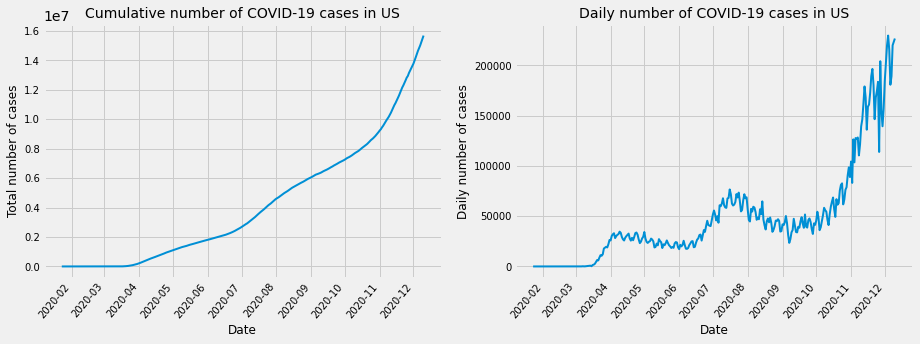

In [9]:
# Plot the time series of cumulative and daily number of COVID-19 cases in US side by side.
plt.style.use('fivethirtyeight')

# Get the x and y values
x1 = df.index
x2 = df.index
y1 = df.total
y2 = df.daily_cases

#Plot the time series and specify the label of x-axis, y-axis, and title in the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes[0].plot(x1, y1, linewidth=2)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Total number of cases', fontsize=12)
axes[0].set_title('Cumulative number of COVID-19 cases in US', fontsize=14)
axes[1].plot(x2, y2, linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Daily number of cases', fontsize=12)
axes[1].set_title('Daily number of COVID-19 cases in US', fontsize=14)
fig.autofmt_xdate(rotation=50)
axes[0].tick_params(labelsize=10)
axes[1].tick_params(labelsize=10)
fig.tight_layout()

As shown in the above plots, the number of cases has been increasing. This increase is especially evident starting in October, where the number of cases has been drastically increasing starting this month. Perhaps the first wave appears to be somewhere around August. However, this wave is less prominant compared to the huge spike that appears in December. It seems that we are in the midst of the second wave.

Now I would like to know: which states account for most of the COVID-19 cases? In order to answer this question, I extracted the cumulative data for the "latest date", which is December 10th, 2020, then I plotted a bar chart as well as a map in order to determine the major contributors to COVID-19 cases in US. The map was visualized in Tableau (the output of the Tableau visualization is displayed as a PNG file).

In [10]:
# filter only for the most recent date, 12/10/20
cases_by_state = df.loc['2020-12-10'].sort_values(ascending=False)

In [11]:
# Create a dataframe
map_US = pd.DataFrame({'state': cases_by_state.index, 'total_cases': cases_by_state})
map_US.drop(index='total', inplace=True)
map_US.to_csv('US_covid_visualization.csv') # export to CSV to be visualized in Tableau
map_US.head()

,state,total_cases
Province_State,,
California,California,1482551.0
Texas,Texas,1443353.0
Florida,Florida,1094697.0
Illinois,Illinois,823531.0
New York,New York,743290.0


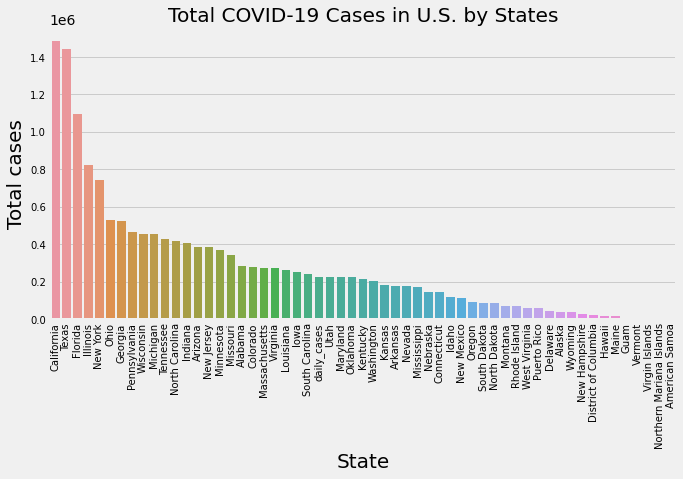

In [12]:
rcParams['figure.figsize'] = 10,5
ax = sns.barplot(y= "total_cases", x = 'state', data = map_US)
ax.set_xlabel("State",fontsize=20)
ax.set_ylabel("Total cases",fontsize=20)
ax.set_title("Total COVID-19 Cases in U.S. by States")
plt.xticks(rotation=90)
ax.tick_params(labelsize=10)
plt.show()

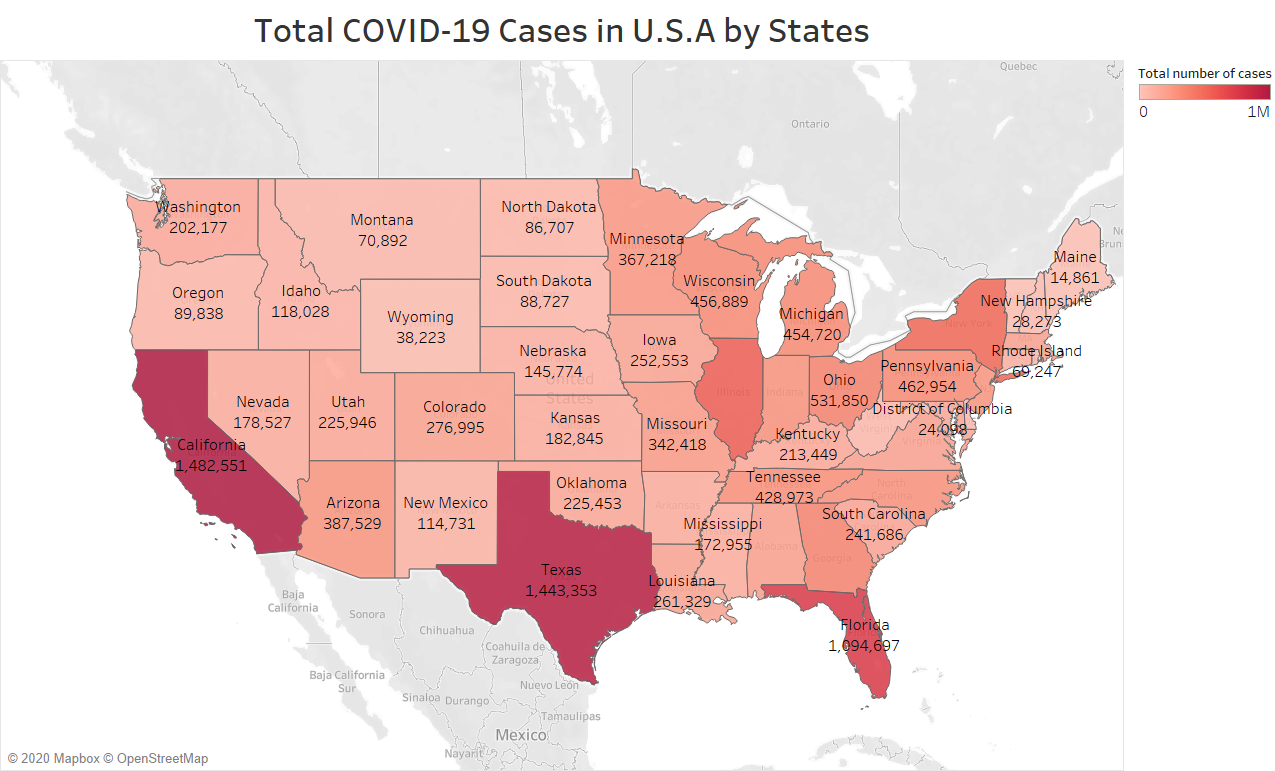

As shown on the map and the bar chart, California has the highest number of COVID-19 cases in the United States, followed by Texas and Florida. Since California is the major contributor to the COVID-19 cases in the states, I will show some visualizations focusing on this state.

In [13]:
# Filter only California data
california = df[['California']]
california.rename(columns={"California": "cumulative_cases"}, inplace=True)

# Calculate daily number of cases
california['daily_cases'] = california.cumulative_cases.diff()
california.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


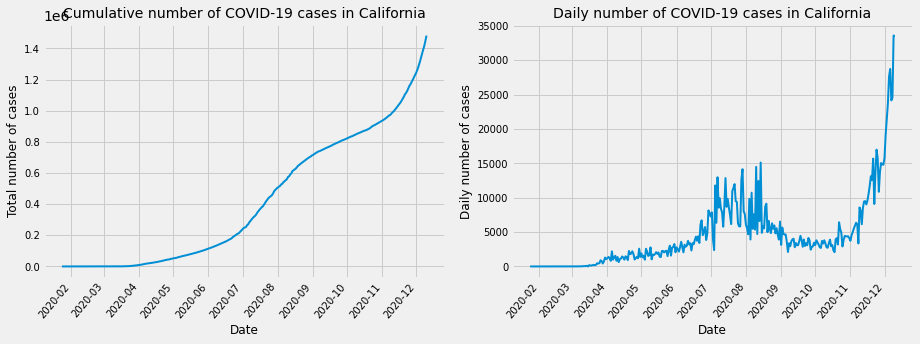

In [14]:
# Plot the time series.
# Get the x and y values
x1 = california.index
x2 = california.index
y1 = california.cumulative_cases
y2 = california.daily_cases

#Plot the time series and specify the label of x-axis, y-axis, and title in the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes[0].plot(x1, y1, linewidth=2)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Total number of cases', fontsize=12)
axes[0].set_title('Cumulative number of COVID-19 cases in California', fontsize=14)
axes[1].plot(x2, y2, linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Daily number of cases', fontsize=12)
axes[1].set_title('Daily number of COVID-19 cases in California', fontsize=14)
fig.autofmt_xdate(rotation=50)
axes[0].tick_params(labelsize=10)
axes[1].tick_params(labelsize=10)
fig.tight_layout()
plt.show()

It appears that the time series for California follows similar trend as the entire US country, where there is a first relatively smaller peak near the month of August, and a significant spike in December. These plots will be helpful later on in parts 3, 4, and 5, when we forecast the data and derive any insights about the pandemic. In part 3, I will model the data using the entire US country. In part 4, I will focus on California since the second dataset I will be using is based on California data. In part 5, I will relate these two findings together to derive an insight about policy to help tackle the outbreak based on my findings from parts 3 and 4.

## Part 3: Model Selection and Fitting to Data

Now that we got some useful insights from the exploratory data analysis, it is time to select the model and fit the data. I have used SIR model to project the time series of COVID-19 cases into the future with three projections: one that assumes worst case spread, another that assumes best case spread, and a third that assumes base-case spread in between the best and worst case. As an extra for this project, I have also performed forecasting using the ARIMA model.

### SIR Model

In the SIR model, there are three groups of people:
1. **Susceptible**: people who do not yet have the virus (they are "healthy") but are susceptible.
2. **Infected**: people who are infected with COVID-19.
3. **Recovered**: people who recovered from the virus and are immune to it. <br>

In addition to these three elements, there are two important parameters to consider when modeling SIR: **beta (β)** and **gamma (γ)**. β is the effective contact rate, which is the number of people an infected person infects per day. γ is the mean recovery rate, where 1/γ represents the mean number of days which the infected person can spread the disease. The equations that illustrate the SIR model is shown below: 

$$\frac{dS}{dt} = -\frac{βSI}{N} $$

$$\frac{dI}{dt} = \frac{βSI}{N} - γI $$

$$\frac{dR}{dt} = γI $$

The following is the summary of relevant variables used:
* N = total population of the region.
* D = recovery period, which is the number of days it takes for the infected person to recover. I.e. number of days the infected can spread the disease.
* R₀ = reproduction number, which is the total number of people the infected person can spread the disease (β/γ).
* β = effective contact rate. Number of people an infected person infects per day.
* γ = mean recovery rate (1/D).

Note: In order to make predictions with the SIR model, it is noteworthy to state three assumptions I had to make:
1. Once you recover from COVID-19, you develop immunity to it, therefore will not get the disease again.
2. I assumed that infected individuals get a 14 day recovery period (D=14).
3. The total population remains constant.

In [15]:
# Create the function for differential equations of the SIR model.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

After doing some research, I found some sources that can help us define the values for our variables. We need the values for the total population of the U.S. country and the number of recovered people. I have used the CSV file of the global recovered time series data from the John Hopkins dataset to determine the number of recovered individuals ("time_series_covid19_recovered_global.csv"). The value at December 10th, 2020 was used because I will be making forecasts from this date. The source used to get the total population can be accessed with this link: https://www.worldometers.info/world-population/us-population/

In [16]:
# Determine the number of recovered people
recovered_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" 
recovered = pd.read_csv(recovered_url)
US_recovered = recovered[recovered['Country/Region'] == 'US']
print("Number of recovered people:", US_recovered['12/10/20'])

# Determine the number of infected people
print("Number of infected people:", df.total.loc['2020-12-10'])

Number of recovered people: 232    5985047
Name: 12/10/20, dtype: int64
Number of infected people: 15689771


In [17]:
# Define the values for the variables.
total_pop = 331_002_651
recovered = 5985047
infected = 15689771
susceptible = total_pop - infected - recovered

What value should we use for the reproduction number (R0)? This value can change depending on how strict the covid restrictions are and the rate of contacts. For example, if the rate of contact is low, then R0 will decrease. On the other hand, if the rate of contact is high, then R0 will increase. The current value is estimated to be 1.05 in the US (https://github.com/youyanggu/covid19_projections/blob/master/r_values/latest_r_values_us.csv). This value will be used as my base-case spread, i.e. the simulation of what would happen if we don't change anything and maintain this rate of contact. This scenario is in between the best and worst case. <br>
In terms of the worst case spread, the value without social distancing restriction is approximately 3.28-5.7, according to various sources: 
(https://www.health.gov.au/sites/default/files/documents/2020/03/coronavirus-covid-19-information-for-clinicians.pdf
https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article and https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) <br>
However, this value varies depending on the country. The previous source from github (latest_r_values_us.csv) estimates the initial R0 value in the United States before the pandemic declaration (before March 15th) to be 2.26. I will use this value to forecast the worst case scenario. This would be a scenario that would happen if nobody followed the social distancing interventions and we did nothing to mitigate the spread. For the best case spread, it occurs when the reproduction number reaches below 1. Although a value of 0 is technically the best case, it is very unrealistic as it is unfeasible to completely not have contact with others. Therefore, I would say that a value of 0.5 would be an optimistic number (when people reduce their rate of contact by about 50% from the current rate).

In [18]:
# recovery rate is 1/D, which is 1/14 days
recovery_rate = 1/14

# Set the values for R0 to simulate the worst, best, and base case scenarios.
contact_rate_base = 1.05 * recovery_rate # Base case
contact_rate_worst = 2.26 * recovery_rate # Worst case
contact_rate_best = 0.5 * recovery_rate # Best case
print("Contact rate worst:", contact_rate_worst)
print("Contact rate base:", contact_rate_base)
print("Contact rate best:", contact_rate_best)

Contact rate worst: 0.1614285714285714
Contact rate base: 0.075
Contact rate best: 0.03571428571428571


In [19]:
# A list of days
days = range(0, 100)

# Actual dates
start = datetime.datetime.strptime("12-11-2020", "%m-%d-%Y")
end = datetime.datetime.strptime("03-21-2021", "%m-%d-%Y")
date_range = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

# Compute the derivation for the base case.
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, contact_rate_base, recovery_rate))
S, I, R = ret.T

# Then, do it again with the adjusted worst one.
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, contact_rate_worst, recovery_rate))
S_worst, I_worst, R_worst = ret.T

# Then, do it again with the adjusted best one.
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, contact_rate_best, recovery_rate))
S_best, I_best, R_best = ret.T

In [20]:
# Define the function for plotting the SIR model
def plotsir(t, S, I, R, case):
  f, ax = plt.subplots(1,1,figsize=(8,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

  ax.set_xlabel('Time (days)')
  ax.set_ylabel('Confirmed cases')
  ax.set_title('SIR model of the ' + case + ' case')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

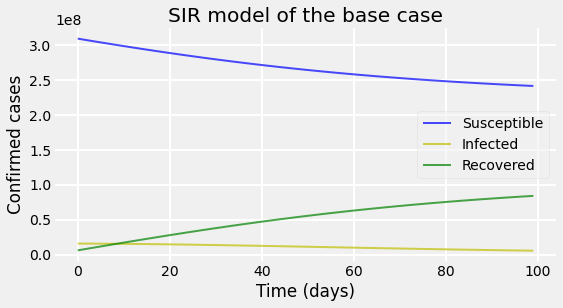

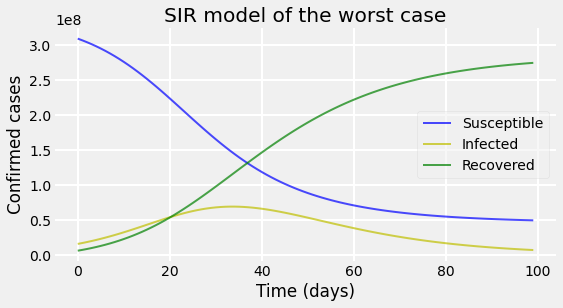

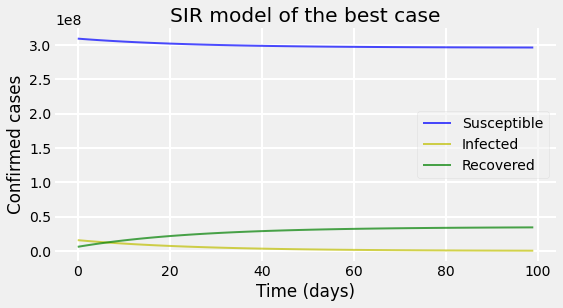

In [21]:
# Plot the SIR for the base, worst, and best case.
plotsir(days, S, I, R, 'base')
plotsir(days, S_worst, I_worst, R_worst, 'worst')
plotsir(days, S_best, I_best, R_best, 'best')

As displayed in the above plots, the worst case scenario had significantly more number of susceptible individuals become infected, as illustrated by the significant drop in the blue curve throughout time. Comparing this plot to the best case scenario, the amount of susceptible inividuals remain relatively stable (the blue line stays fairly horizontal, there is only a very slight decrease during the 100 day period). The base case is not bad as well. It is a bit worse than the best case, however, it looks like the second wave could end soon and things might get better if we maintain the same social distancing practices and interventions.

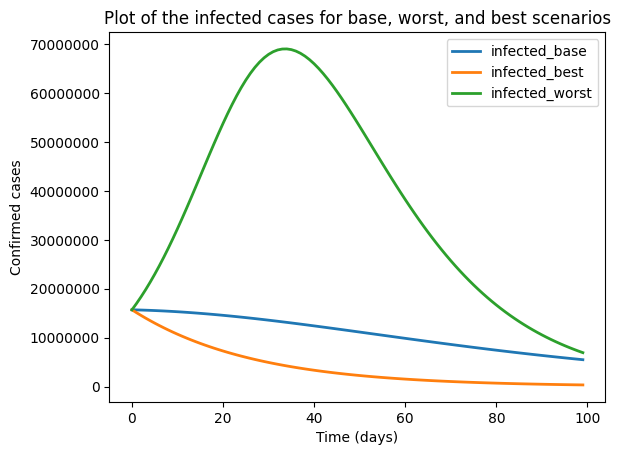

In [22]:
# Build a dataframe
sir_data = pd.DataFrame({
    'infected_base': I,
    'infected_best': I_best,
    'infected_worst': I_worst,
    'day': days,
    'date': date_range})

plt.style.use('default')
ax = sir_data.plot(x='day', y = ['infected_base', 'infected_best', 'infected_worst'], linewidth=2)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Confirmed cases')
ax.set_title('Plot of the infected cases for base, worst, and best scenarios')
plt.ticklabel_format(style='plain', axis='y')
ax.legend()
plt.show()

Just to visualize the comparison between the three scenarios, the above figure plots the number of infected cases over the period of 100 days. Next, I will create another plot that visualizes the long-range forecast from the beginning (January 22, 2020) and predict the future (until May 4, 2021).

In [23]:
# Display the first five rows of the SIR data
sir_data.head()

,infected_base,infected_best,infected_worst,day,date
0,1.568977e+07,1.568977e+07,1.568977e+07,0,2020-12-11
1,1.566682e+07,1.510352e+07,1.697679e+07,1,2020-12-12
2,1.564002e+07,1.453839e+07,1.834663e+07,2,2020-12-13
3,1.560941e+07,1.399368e+07,1.980069e+07,3,2020-12-14
4,1.557505e+07,1.346870e+07,2.133967e+07,4,2020-12-15


In [24]:
# set the first and last date of forecast
start_date = "2020-12-11"
end_date = "2021-05-04"

after_start_date = sir_data["date"] >= start_date
before_end_date = sir_data["date"] <= end_date
between_two_dates = after_start_date & before_end_date
sir_data = sir_data.loc[between_two_dates]

# Extract the forecast date
forecast_date = sir_data.date.tolist()

In [25]:
# Extract the 'total' column to get the cumulative sum of cases
US_total = df[['total']]

In [26]:
# concatenate the historical data with the forecast data to visualize the long-range forecast
historical_date = US_total.index.tolist()
historical_values = US_total.total.tolist()

complete_date = historical_date + forecast_date
base = historical_values + sir_data.infected_base.tolist()
best = historical_values + sir_data.infected_best.tolist()
worst = historical_values + sir_data.infected_worst.tolist()

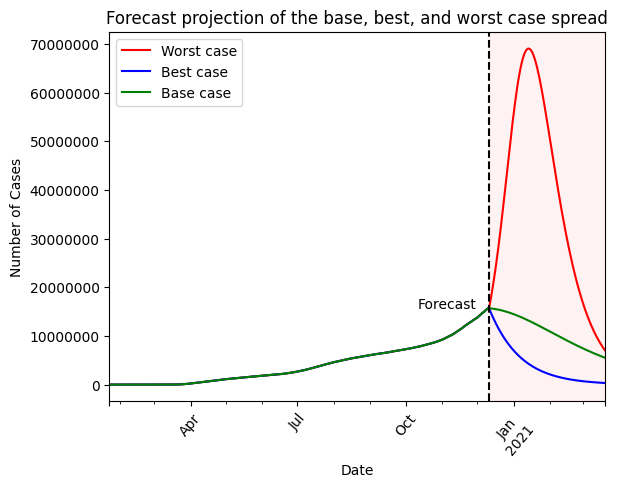

In [27]:
# Build a dataframe, starting date from the beginning, 01-22-2020 to the end
df_forecast = pd.DataFrame({
    'date': complete_date,
    'base_case': base,
    'best_case': best,
    'worst_case': worst})

ax = df_forecast.plot(x='date', y = ['worst_case', 'best_case', 'base_case'], label = ['Worst case', 'Best case', 'Base case'], color=['r','b','g'])
ax.legend()
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Forecast projection of the base, best, and worst case spread')
plt.xticks(rotation=50)
plt.ticklabel_format(style='plain', axis='y')
ax.axvspan('2020-12-11', '2021-03-20', color='red', alpha=0.05)
ax.axvline('2020-12-11', color='black', linestyle='--')
ax.annotate('Forecast', xy=('2020-10-11', df_forecast.base_case[df_forecast.date == '2020-12-11']))
plt.show()

In [28]:
# Find when the peak of the second wave will occur from the worst case scenario
df_forecast[df_forecast.worst_case == max(df_forecast.worst_case)]

,date,base_case,best_case,worst_case
357,2021-01-14,1.311701e+07,4.209621e+06,6.904417e+07


It is interesting to see how the scenario diverges radically when we simulate the best and worst cases, simply by changing the parameters in the SIR model. From this graph we can learn that if we do nothing to mitigate COVID-19 pandemic and ignore social distancing measures, then the epidimic is forecast to resurge at an alarming rate (shown in the red curve). In the worst case scenario, the peak of the second wave is yet to come. It is forecasted to peak abruptly at 69 million cases around mid January. However, if we reduce our current rate of contact by around 50%, then the worst is over as the number of cases will decrease significantly.

Important insights have been derived from SIR modeling. Now, I am curious to know what results other models could give us. Consequently, I have also tried the ARIMA model to make forecasts.

### ARIMA model (Extra)

For the ARIMA model, I followed the Box-Jenkins method. I first started with the time series data and identified the best parameters for my model. Next, I made estimation, followed by diagnosing the model's performance. Finally, if the model is okay, I go ahead and make predictions. <br>
<br>
**Box-Jenkins Method** <br>
Time series --> Identification --> Estimation --> Model diagnostic --> Forecasting

In [29]:
US = df[['total', 'daily_cases']]

#### Searching for the best order for the model

In [30]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over d values from 0-2
  for d in range(3):
    # Loop over q values from 0-2
      for q in range(3):
      	# create and fit ARIMA(p,d,q) model
        model = SARIMAX(US.daily_cases, order=(p,d,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, d, q, results.aic, results.bic))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

In [31]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'd', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC')

,p,d,q,AIC,BIC
17,1,2,2,6804.772430,6819.858195
8,0,2,2,6823.663531,6834.977854
16,1,2,1,6838.043072,6849.357395
13,1,1,1,6840.178486,6851.502141
5,0,1,2,6840.833251,6852.156906
23,2,1,2,6841.054582,6859.927340
22,2,1,1,6841.944185,6857.042392
14,1,1,2,6842.020091,6857.118297
4,0,1,1,6842.364459,6849.913562
26,2,2,2,6842.963239,6861.820445


p, d, q values of 1, 2, 2 respectively were the best parameters. Therefore, I use these values to fit the ARIMA model.

#### Fitting an ARIMA model

In [32]:
# Create ARIMA model
arima = SARIMAX(US.daily_cases, order=(1, 2, 2))

# Fit ARIMA model
arima_results = arima.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


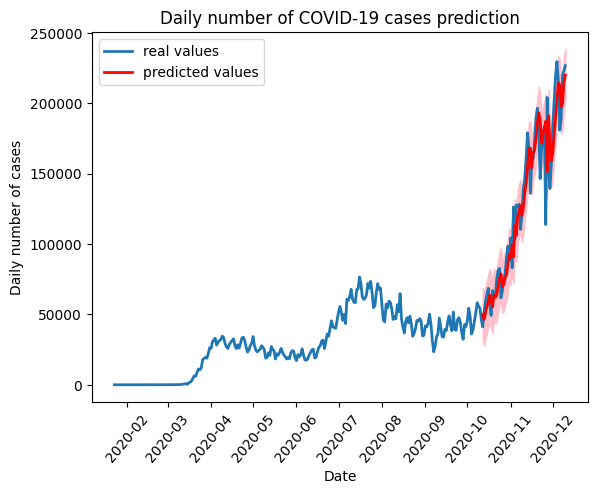

In [33]:
# Make predictions
one_step_forecast = arima_results.get_prediction(start=-60) # to get predictions

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower daily_cases']
upper_limits = confidence_intervals.loc[:,'upper daily_cases']

# plot the data
plt.plot(US.index, US.daily_cases, linewidth=2, label='real values')

# plot your mean predictions / forecast
plt.plot(mean_forecast.index, mean_forecast.values, color='r', linewidth=2, label='predicted values')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date', fontsize=10)
plt.ylabel('Daily number of cases', fontsize=10)
plt.title('Daily number of COVID-19 cases prediction')
plt.legend(loc='upper left')
plt.xticks(rotation=50)
ax.tick_params(labelsize=14)
plt.show()

The predicted values appear to be very close to the real values as they are within the confidence intervals. This model seems to be performing well. Next, I want to make forecast and predict the future of next 60 days.

In [34]:
# Make arima forecast of next 30 differences
one_step_forecast = arima_results.get_forecast(steps=60) # to get forecast

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower daily_cases']
upper_limits = confidence_intervals.loc[:,'upper daily_cases']

# Print first five values of the forecast
print(mean_forecast[:5])

2020-12-11    224703.348020
2020-12-12    226370.112530
2020-12-13    229093.224273
2020-12-14    232122.270225
2020-12-15    235239.919372
Freq: D, dtype: float64


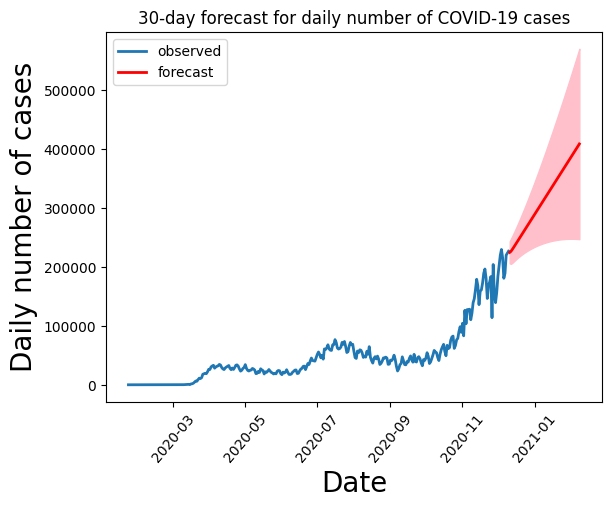

In [35]:
# plot the data
plt.plot(US.index, US.daily_cases, linewidth=2, label='observed')

# plot your mean predictions / forecast
plt.plot(mean_forecast.index, mean_forecast.values, color='r', linewidth=2, label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date', fontsize=20)
plt.ylabel('Daily number of cases', fontsize=20)
plt.title('30-day forecast for daily number of COVID-19 cases')
plt.legend(loc='upper left')
plt.xticks(rotation=50)
ax.tick_params(labelsize=14)
plt.show()

The forecast produced by ARIMA suggests that the number of daily COVID-19 cases are increasing, and we are not yet near the peak of the pandemic.

#### Model diagnostics

In order determine how accurate my predictions are, I have computed the mean absolute error (MAE), which tells us the mean difference between the predicted and true values.

In [36]:
# Fit model
model = SARIMAX(US.daily_cases, order=(1, 2, 2))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print("Mean Absolute Error is:", mae)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error is: 5336.239505438124


In [37]:
# Print summary
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:            daily_cases   No. Observations:                  323
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -3398.386
Date:                Sat, 19 Dec 2020   AIC                           6804.772
Time:                        07:05:31   BIC                           6819.858
Sample:                    01-23-2020   HQIC                          6810.796
                         - 12-10-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2896      0.033      8.710      0.000       0.224       0.355
ma.L1         -1.7585      0.022    -80.611      0.000      -1.801      -1.716
ma.L2          0.7758      0.022     35.563      0.0

The MAE is 5336. The summary results show two important things:
1. The p-value of Ljung-Box is below 0.05, which means that we reject the null hypothesis that there are no correlations in the residual.
2. The p-value of Jarque-Bera is below 0.05, which means that we reject the null hypothesis that the residuals are normally distributed.
<br>
Therefore, there are correlations in the residual and the residuals are not normally distributed.

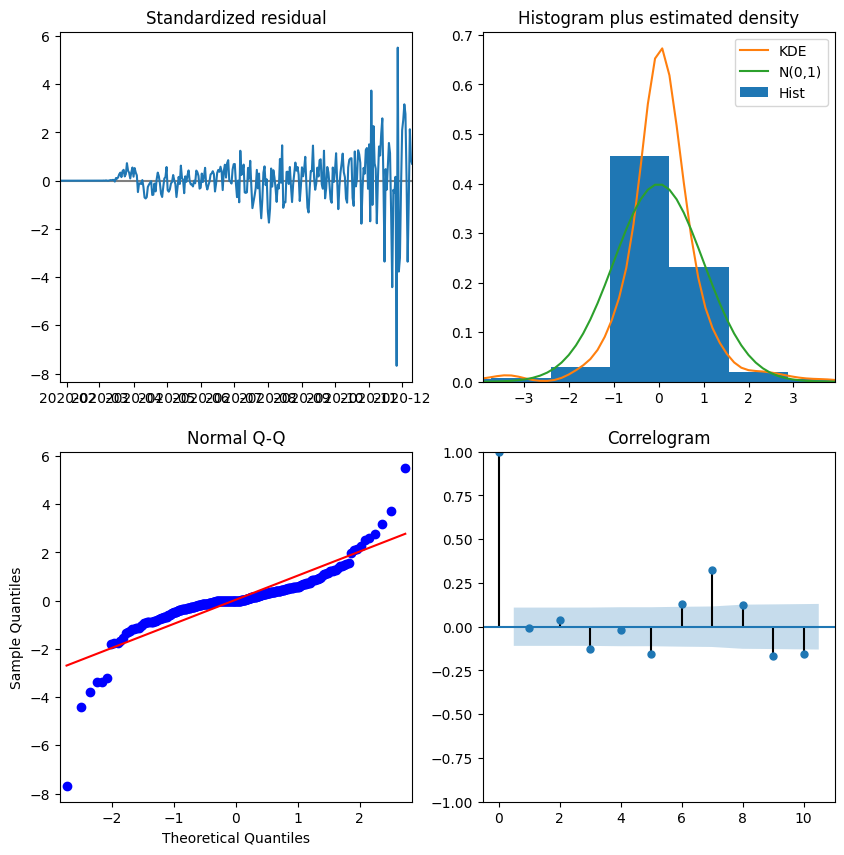

In [38]:
# Create the 4 diagostics plots
plt.style.use('default')
results.plot_diagnostics(figsize=(10,10))
plt.show()

From the plot diagnostics, it can be inferred that the model is not a good fit based on these four reasons:
1. From the standardized residual plot, there appears to be a pattern in the residuals since there is a big spike at the end.
2. From the histogram plus KDE estimate, the KDE curve is very different from the normal distribution (the green and red distribution are not very similar).
3. From the normal Q-Q plot, not many of the points lie along the red line.
4. From the correlogram, 95% of the correlations for lag greater than one is not significant.

Therefore, based on these reasons, I would probably not rely on this ARIMA model. In conclusion, I think SIR model gives a better interpretation of the COVID-19 pandemic forecasts, so I will choose the SIR model over ARIMA model.

## Part 4: Relating COVID-19 Projections to Twitter Social Mobility Data

Next step involved using a another dataset to examine and analyze a factor that is related to COVID-19. I have looked at the Twitter Social Mobility Data extracted from geolocated Twitter data, which is a metric used to measure the social distancing and travel. The mobility index specifically determines how much a person travels in a given week. I will be using this information to answer the following questions: 
* Is there a correlation between social mobility index and the number of COVID-19 cases?
* How much social distancing should be done, and how much should people reduce their mobility in order to optimally reduce the spread of the pandemic?

Link to the data source:
https://socialmobility.covid19dataresources.org/data.html

Note: Because the social mobility data contained data for each individual states instead of the entire country, I decided to use data from California to make analysis. Justification for selecting California is because, as aforementioned in part 2 (exploratory data analysis), California was the top contributor of COVID-19 cases in the United States. Therefore, it would be reasonable to apply the insights and guidance obtained from California to the entire country.

### Correlating social distancing metrics to the number of COVID-19 cases

In [40]:
# Load the dataset
df2 = pd.read_csv('longitudinal_compiled.csv')
df2.head()

,Dates,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,...,Nashville,New York City,New Orleans,Newark,Norfolk,North Las Vegas,Oakland,Oklahoma City,Omaha,Orlando,Philadelphia,Phoenix,Pittsburgh,Plano,Portland,Raleigh,Reno,Richmond,Riverside,Sacramento,San Antonio,San Diego,San Francisco,San Jose,Santa Ana,Scottsdale,Seattle,Spokane,St Louis,St Paul,St Petersburg,Stockton,Tampa,Toledo,Tucson,Tulsa,Virginia Beach,Washington,Wichita,Winston-Salem
0,2019-01-01,89.269094,56.342487,47.024894,70.079272,77.583180,66.170215,39.831145,82.876133,37.660207,77.125171,67.955291,185.203309,57.351650,64.726634,53.851274,56.167114,66.273457,44.336905,52.760747,54.703755,40.984609,53.231781,57.256474,55.473439,49.392972,55.854495,78.028736,48.507490,84.224531,63.143547,56.344148,39.072765,67.492730,74.059398,70.414191,48.781406,55.455333,72.619646,50.624436,...,70.492043,83.101791,54.078945,54.601345,60.127138,33.327983,73.757310,49.422806,59.791231,87.766423,47.522757,57.910897,52.408893,71.117668,72.834616,43.174737,60.703607,51.238761,44.666982,54.454848,44.244214,89.528649,121.389244,63.252435,25.048623,88.313560,97.745564,45.420337,54.475132,47.955346,43.132366,42.507914,67.862228,31.119167,51.694447,57.212679,45.499874,83.558629,38.032459,31.775158
1,2019-01-07,109.257733,53.864956,46.710076,60.771483,72.295714,62.414312,42.448752,72.386975,34.755833,69.788057,61.900962,167.024251,48.208959,72.055749,53.631828,38.527947,63.902021,38.199566,43.707069,54.417880,40.065683,61.145720,52.711304,59.473522,45.400217,45.391005,75.675468,45.361228,62.065792,45.529641,59.115553,46.602058,53.212509,72.221442,71.223914,41.984935,49.892741,63.231582,51.975216,...,65.745193,85.817861,55.767274,58.201641,42.994002,38.058461,83.464591,41.074754,46.062552,95.171554,53.060413,57.223366,46.518560,53.671613,70.287429,41.164590,55.562349,47.557308,32.272411,60.869460,39.795813,71.672478,97.265990,64.826306,36.739060,75.572987,70.420643,44.989582,51.214622,54.782169,61.263123,31.901197,66.154773,36.752779,63.331993,40.700586,35.378267,73.378881,32.315637,41.411460
2,2019-01-14,96.573495,37.911090,42.499952,53.815111,72.681429,66.167248,46.620785,68.416178,32.419117,72.045375,61.931224,123.939242,36.485392,68.682367,48.477958,37.071667,59.032206,37.072017,40.450225,56.595412,39.614827,54.414931,50.202756,64.753596,46.711586,45.306035,53.349522,44.792447,52.272637,42.984111,44.874856,47.525934,45.859412,71.867928,72.111407,36.515588,44.320345,61.011483,49.718579,...,64.372576,86.463319,51.381326,55.843354,38.097564,38.194956,79.520407,37.523720,37.375634,95.060412,47.240884,55.877322,55.429805,57.905914,70.063820,40.190539,48.596445,37.745582,33.949400,48.136269,37.528059,66.353778,107.758655,54.234072,38.502017,74.061572,77.668010,56.959411,46.978838,56.319743,46.453650,33.709669,78.960493,34.478056,49.374296,39.568618,53.373438,69.189199,31.948345,23.935399
3,2019-01-21,96.449995,41.139050,46.651845,65.683969,72.853855,66.609446,43.716240,78.076018,33.305566,79.812298,66.497644,132.940996,38.550620,68.732599,50.825904,35.531594,56.183977,38.144691,39.416818,57.038138,43.389463,64.424234,50.214072,64.207363,47.842797,41.880073,67.121073,45.275326,55.477674,46.460861,42.981713,50.563557,48.930065,74.805242,81.205704,38.688214,41.604128,73.233336,51.781620,...,75.069662,94.599253,48.245013,48.688130,26.753567,40.363183,72.533311,37.543986,45.274546,91.087702,50.546846,55.319434,60.409922,54.439483,82.909569,42.033825,44.309027,41.916487,39.410459,51.588594,39.839691,70.706160,107.364340,57.384798,34.562739,95.270458,89.625688,52.143672,54.552625,57.418002,68.396496,25.901705,70.700320,36.109442,34.743503,43.134973,45.008685,77.141172,36.458285,37.875574
4,2019-01-28,107.333975,34.767035,45.167911,86.270509,75.244531,61.414464,38.634445,66.354448,39.187992,80.423560,74.393201,107.815768,39.408240,58.639674,47.441543,38.793462,52.754106,38.177552,36.727905,54.056013,35.941433,70.466434,46.036194,58

In [41]:
# Extract only the dates and California 'CA' column
df2 = df2[['Dates', 'CA']]
# Rename the columns to more appropriate names
df2.rename(columns={'CA': 'social_mobility_index', 'Dates': 'date'}, inplace=True)

# Convert the date column to a datestamp type
df2['date'] = pd.to_datetime(df2['date'])

# Filter only the dates relevant for the pandemic period
df2.set_index('date', inplace=True)
df2 = df2.loc["2020-01-23": "2021-12-10"]

# Since this is a weekly data, I have changed it to daily data, and filled the missing values with forward fill.
df2 = df2.asfreq('D', method='ffill') #forward fill
df2 = df2.fillna(method='ffill') # fill na values with preceding values

In [42]:
# Also prepare the dataset from the John Hopkins dataset.
california = california.loc['2020-01-27':'2020-12-07']

# Check to ensure that the date length of the social mobility data is equal to the John Hopkins california data.
print(len(df2) == len(california))

True


In [43]:
# Combine the social mobility data and John Hopkins data.
# Add columns for daily and cumulative cases from the John Hopkins data to the second datset.
df2['daily_cases'] = california.daily_cases.tolist()
df2['cumulative_cases'] = california.cumulative_cases.tolist()

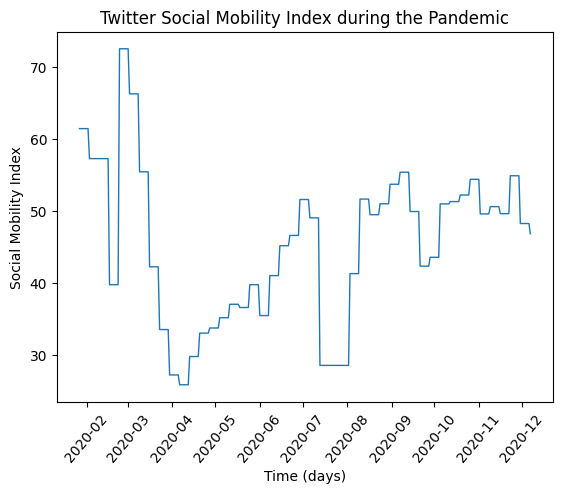

In [44]:
# Plot the Social mobiltiy index
ax = plt.plot(df2.index, df2.social_mobility_index, linewidth=1)
plt.xlabel('Time (days)')
plt.ylabel('Social Mobility Index')
plt.title('Twitter Social Mobility Index during the Pandemic')
plt.xticks(rotation=50)
plt.show()

It is evident that the social mobility index varies throughout February to December. People seem to be moving a lot in February and March, while reductions in mobility is seen near April and July/August. <br>
<br>
I would assume that social mobility will have an effect on the number of cases after a certain consecutive number of days. In other words, if the social mobility increased on February, then this may increase the number of cases after a certain period, but probably not on that same day. I will determine when the correlation value is high by shifting the days of the COVID-19 cases.

In [45]:
# Calculate the correlation values between the social mobility index and the number of cumulative cases after certain period.
correlation_values = []
shifted_days = []

for days in range(0,60):
  shifted_days.append(days)
  correlation_values.append(df2['social_mobility_index'].corr(df2['cumulative_cases'].shift(periods=days))) # moving data to the future

print("The maximum correlation value is", max(correlation_values), "when date is shifted by", correlation_values.index(max(correlation_values)), "days.") #find the maximum correlation value

The maximum correlation value is 0.6765116989949472 when date is shifted by 49 days.


In [46]:
# Display the correlation values between the mobility index and the cumulative number of cases after certain period.
df_correlation = pd.DataFrame({'shifted_days': shifted_days, 'correlation_values': correlation_values})
df_correlation

,shifted_days,correlation_values
0,0,0.258999
1,1,0.267238
2,2,0.275612
3,3,0.284059
4,4,0.292598
5,5,0.301202
6,6,0.309868
7,7,0.318647
8,8,0.325682
9,9,0.332860


It is interesting to note that the correlation value is very low (0.26) on day 0 but highest after day 49 (0.68). What this data is telling us is that the social mobility do not have an effect on the number of COVID-19 cases from the beginning. You start to see its consequence after a certain period of time, in this case, typically after 49 days. Logically, this makes sense since you start to see the emergence of symptoms not at the beginning, but after a certain period.

In [47]:
# Add a new column 'shifted' to include data of the confirmed cases shifted by 49 days.
df2['shifted'] = df2.cumulative_cases.shift(periods=49)

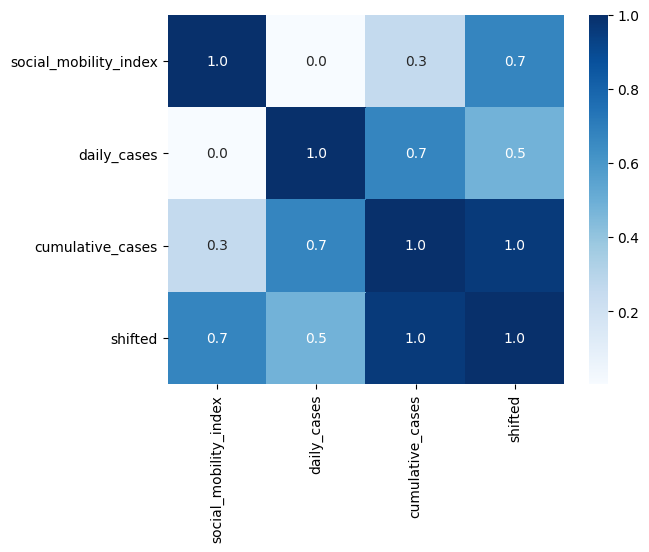

In [48]:
# Display a heatmap showing correlation between mobility index and the number of cases (daily, cumulative, and shifted)
sns.heatmap(df2[['social_mobility_index', 'daily_cases', 'cumulative_cases', 'shifted']].corr(), annot=True, fmt='.1f', cmap="Blues")

When I plotted the mobility index vs. total number of cases (after 49 days), it looks like this could potentially be a linear relationship. Therefore, I will try to build a linear regression model to make predictions and find any insights.

Text(0.5, 0, 'Social mobility index')

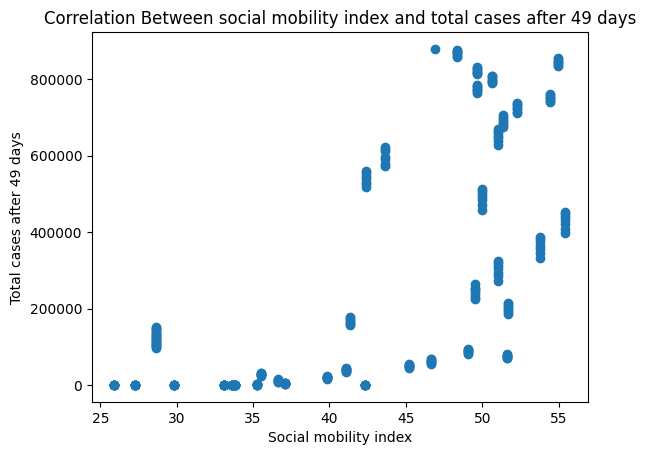

In [49]:
# correlation plot
x = df2.social_mobility_index
y = df2.shifted
plt.scatter(x,y)
plt.title("Correlation Between social mobility index and total cases after 49 days")
plt.ylabel("Total cases after 49 days")
plt.xlabel("Social mobility index")

### Performing Linear Regression to make predictions

I will perform linear regression and plot the relationship between the social mobility index and the total number of cases after 49 days in order to make predictions.

In [50]:
# Load the packages required for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [51]:
# Make sure to drop any missing values
df2.dropna(inplace=True)

In [52]:
# Create a linear regresion object
lm = LinearRegression() 
# Define the predictor and target variable, X and y
X = df2[['social_mobility_index']]
y = df2[['shifted']]
# Fit the model and find the intercept and the coefficient
lm.fit(X,y)
# obtain prediction
Yhat = lm.predict(X)
print("Intercept:", lm.intercept_)
print("Coefficient:", lm.coef_)

# Calculate R squared
print('The R-squared is:', lm.score(X,y))

# Predict the output, i.e. Yhat using the predict method, where X is the input variable.
Yhat = lm.predict(X)

# Calculate MSE. Compare the predicted results with the actual results
mse = mean_squared_error(df2.shifted, Yhat)
print('The mean square error of case number after 49 days and predicted value is:', mse)

Intercept: [-713215.76131921]
Coefficient: [[23410.26497213]]
The R-squared is: 0.4576680788770301
The mean square error of case number after 49 days and predicted value is: 53083653798.67693


The R-squared value is 0.46, which means that 46% of the variation in social mobiltiy is explained by the COVID-19 case numbers after 49 days.

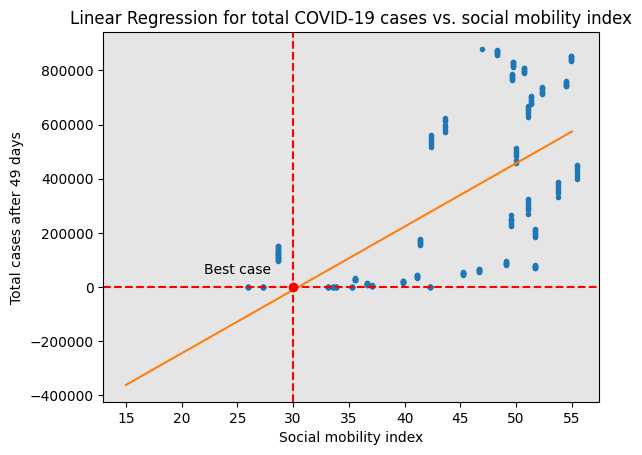

In [53]:
new_input = np.linspace(15, 55, 100).reshape(-1,1)
#fit the model
lm.fit(X,y)
#produce a prediction
Yhat = lm.predict(new_input)

# plot the data
plt.plot(X, y, '.', new_input, Yhat, '-')
plt.title('Linear Regression for total COVID-19 cases vs. social mobility index')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))
fig = plt.gcf()
plt.xlabel('Social mobility index')
plt.ylabel('Total cases after 49 days')
ax.axhline(0, color='red', linestyle='--')
ax.axvline(30, color='red', linestyle='--')
ax.annotate('Best case', xy=(22, 50000))
plt.plot(30,0,'ro') 
plt.show()
plt.close()

From fitting the line of best fit for the linear regression model, it can be deduced that for the number of cases to be zero, we must restrict our movement to about 30 kilometers.

## Part 5: Deriving insights about policy and guidance to tackle the outbreak based on model findings

As shown in Part 3, forecasting was made, projecting the base-case, worst case, and best case scenarios. I deduced that the reproduction number (R0) for the worst case to be 2.26, best case to be 0.5, and base case to be 1.05. In other words, it was roughly estimated that an average of 2.26 people is infected by the infected person for the worst case scenario, 0.5 for the best case scenario, and 1.05 for the base-case scenario. We saw what would happen if we do not take any action to mitigate the spread of the pandemic (for example, no social distancing, no interventions, no lockdowns, etc.). If we do not do anything, the epidemic is forecast to resurge at an alarming rate and reach its maximum of 69 million cases in USA. However, if we reduce our current rate of contact by around 53%, then the worst is over as the number of cases will decrease significantly. Therefore, the change in taking action makes a huge difference in attenuating this serious situation. In part 4, I looked at the Twitter social mobility data and investigated how mobility and social distancing metrics affect the pandemic. It was shown that, as a matter of fact, how much a person travels have a strong influence in the rise of the COVID-19 cases. Correlation was shown to be 0.68, which was fairly high. The more people move, the higher the number of cases after 49 days. As displayed in the linear regression plot in part 4, in order to optimally reduce the spread of the pandemic, we must reduce our mobility by about 36%. Mobility is measured in kilometers, and the data suggests that currently, the value is at 46.9 kilometers. The optimal value we want to reach is around 30 kilometers.

In [54]:
# Show the number of cases for the base, best, and worst case near mid-march 2021.
df_forecast.tail()

,date,base_case,best_case,worst_case
418,2021-03-16,5.859448e+06,382020.540365,8.362400e+06
419,2021-03-17,5.763767e+06,367244.646193,7.978231e+06
420,2021-03-18,5.669242e+06,353039.810363,7.610990e+06
421,2021-03-19,5.575874e+06,339383.996883,7.259998e+06
422,2021-03-20,5.483664e+06,326256.017353,6.924601e+06


The above data shows the number of cases for the base, best, and worst case scenario in mid-march. We can see that the total number of COVID-19 cases will be reduced to around 330,000 in March 20, 2021 for the best case scenarios, that is, if we reduce our rate of contact by 53%. This number of cases will be very low compared to the total population in the country. Consequently, I would assume that around this date would be a good time to relax the social distancing measures if we make a strict lockdown from December 11, 2020.

In [55]:
# Determine the latest social mobility value
latest_SMI = df2.social_mobility_index[-1]
print("The latest social mobility index is", latest_SMI)

# By how much should we reduce our mobility?
percent_change = (30 - latest_SMI) / latest_SMI * 100
print("We should reduce our mobility by", -round(percent_change, 2), "percent in order to effectively prevent the pandemic.")

The latest social mobility index is 46.89757633350478
We should reduce our mobility by 36.03 percent in order to effectively prevent the pandemic.


The social mobility data is telling us that currently, we are moving around 47 km on average. This value must be dropped to 30 km in order to effectively prevent the pandemic. I.e. reduce the mobility to 36%. By implementing this policy, the total number of COVID-19 cases will drop to 0 after 49 days.

In summary, from the findings of my models in part 3 and 4, I propose the following guidance to prevent the spread of COVID-19:
* We should make stricter restrictions immediately by implementing a strict lockdown. We must shut down everything immediately in December 2020.
* The recommended date to end the lockdown and open everything would probably be around March. As shown in the forecasted data from the SIR model, in March 20, 2021, the number of cases decrease to around 300,000 cases for the best case scenario.
* We must limit social contact as much as possible by avoiding large gatherings
* Also, it is essential to reduce mobility by 36% by:
    * avoiding travel unless necessary
    * staying home as much as possible